# diSPIM Data Visualization Pipeline

This notebook provides a complete pipeline to load, process, and visualize high-resolution microscopy data from a double diSPIM (dual-view selective plane illumination microscopy) system.

## Overview

The data consists of:
- **Two imaging arms**: Alpha and Beta (each diSPIM)
- **Two cameras per arm**: Each arm has 2 cameras that need to be spatially aligned
  - Alpha arm: ['HamCam2', 'HamCam1']
  - Beta arm: ['HamuHam4', 'HamuHam3']
- **Z-stacks**: 200 slices per volume
- **High resolution**: 2304×2304 pixels per slice
- **Format**: OME-TIFF files with detailed JSON metadata

## Goals

1. Load OME-TIFF image stacks from both alpha and beta arms
2. Visualize camera overlays to understand spatial relationships within each arm
3. Understand what transformations are needed to align cameras
4. Display data to assess alignment quality


## Section 1: Setup and Imports

First, we import all necessary libraries for data loading, processing, and visualization.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import utility functions from utils.py
from utils import (
    parse_metadata,
    load_ome_tiff,
    discover_acquisitions,
    calculate_temporal_alignment,
    extract_spatial_info,
    scale_image_for_display,
    create_side_by_side_frame,
    create_camera_overlay,
    display_camera_overlays,
    create_video_from_stacks
)

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")


Libraries imported successfully!


## Section 2: Data Discovery and Loading

First, we'll discover all available acquisitions and load the data. The utility functions handle:
- Parsing metadata JSON files
- Loading OME-TIFF image stacks
- Discovering alpha/beta acquisition pairs


In [2]:
# Discover all acquisitions
acquisitions = discover_acquisitions('./datasets')
print(f"Found {len(acquisitions)} acquisition pairs:")
for i, acq in enumerate(acquisitions):
    print(f"  {i+1}. {acq['condition']}/{acq['run']}: alpha={acq['alpha_path'].name}, beta={acq['beta_path'].name}")


Found 9 acquisition pairs:
  1. 10msec_worm/I: alpha=beads_alpha_worm2_4, beta=beads_beta_worm2_4
  2. 1msec_worm/I: alpha=beads_alpha_worm2, beta=beads_beta_worm2
  3. 1msec_worm/II: alpha=beads_alpha_worm2_1_1, beta=beads_beta_worm2_1_1
  4. 200msec_worm/I: alpha=beads_alpha_worm2, beta=beads_beta_worm2
  5. 200msec_worm/II: alpha=beads_alpha_worm2_1, beta=beads_beta_worm2_1
  6. 200msec_worm/III: alpha=beads_alpha_worm2_2, beta=beads_beta_worm2_2
  7. 200msec_worm/IV: alpha=beads_alpha_worm2_3, beta=beads_beta_worm2_3
  8. 20msec_worm/I: alpha=beads_alpha_worm2_2_1, beta=beads_beta_worm2_2_1
  9. Worm1_starved_adult_SWF1188/I: alpha=worm_alpha, beta=worm_beta


## Section 3: Select and Load Acquisition

Select an acquisition to work with and load its metadata and image data.


In [ ]:
# Select an acquisition to work with
# You can change this index to select a different acquisition
ACQUISITION_INDEX = 1  # 0 = first acquisition, 1 = second, etc.

if len(acquisitions) > ACQUISITION_INDEX:
    selected_acq = acquisitions[ACQUISITION_INDEX]
    print(f"Selected acquisition: {selected_acq['condition']}/{selected_acq['run']}")
    print(f"  Alpha: {selected_acq['alpha_path'].name}")
    print(f"  Beta: {selected_acq['beta_path'].name}")
else:
    print(f"Error: Acquisition index {ACQUISITION_INDEX} not available. Found {len(acquisitions)} acquisitions.")
    selected_acq = None


Selected acquisition: Worm1_starved_adult_SWF1188/I
  Alpha: worm_alpha
  Beta: worm_beta


### Load Metadata and Image Data

Load metadata and image stacks for the selected acquisition. Note: Loading full stacks can be memory-intensive (~4.2 GB per arm).


In [5]:
# Load metadata for selected acquisition
if selected_acq:
    print("Loading metadata...")
    alpha_meta = parse_metadata(selected_acq['alpha_metadata'])
    beta_meta = parse_metadata(selected_acq['beta_metadata'])
    
    print("\nAlpha metadata summary:")
    print(f"  Dimensions: {alpha_meta['width']}×{alpha_meta['height']}×{alpha_meta['slices']}")
    print(f"  Cameras: {alpha_meta['channels']} ({', '.join(alpha_meta['channel_names'])})")
    print(f"  Start time: {alpha_meta['start_time']}")
    
    print("\nBeta metadata summary:")
    print(f"  Dimensions: {beta_meta['width']}×{beta_meta['height']}×{beta_meta['slices']}")
    print(f"  Cameras: {beta_meta['channels']} ({', '.join(beta_meta['channel_names'])})")
    print(f"  Start time: {beta_meta['start_time']}")
    
    # Calculate temporal alignment
    alignment = calculate_temporal_alignment(alpha_meta, beta_meta)
    print(f"\nTemporal alignment:")
    print(f"  Time offset: {alignment['time_offset_sec']:.3f} seconds")
    print(f"  Average slice period: {alignment['slice_period_ms']:.2f} ms")
    
    # Extract spatial info
    spatial = extract_spatial_info(alpha_meta, beta_meta)
    print(f"\nSpatial information:")
    print(f"  Pixel size: {spatial['pixel_size_um']['average']:.4f} μm/pixel")
    print(f"  Z-step: {spatial['z_step_um']['average']:.4f} μm/slice")
    print(f"  Volume size: {spatial['physical_dimensions_um']['xy']['width']:.2f} × {spatial['physical_dimensions_um']['xy']['height']:.2f} × {spatial['physical_dimensions_um']['z']['depth']:.2f} μm")
else:
    print("No acquisition selected.")


Loading metadata...

Alpha metadata summary:
  Dimensions: 2304×2304×400
  Cameras: 2 (HamCam2, HamCam1)
  Start time: 2025-10-19 22:15:10 -0400

Beta metadata summary:
  Dimensions: 2304×2304×400
  Cameras: 2 (HamuHam3, HamuHam4)
  Start time: 2025-10-19 22:18:24 -0400

Temporal alignment:
  Time offset: 194.000 seconds
  Average slice period: 211.50 ms

Spatial information:
  Pixel size: 0.1220 μm/pixel
  Z-step: 0.3000 μm/slice
  Volume size: 281.09 × 281.09 × 120.00 μm


In [6]:
# Set maximum slices to load (None = load all, smaller number = faster loading for testing)
MAX_SLICES_FOR_DISPLAY = None  # Load full stack  # Change this to load more/fewer slices

if selected_acq:
    print("Loading OME-TIFF files...")
    print("This may take a few moments for large files...")
    
    # Load alpha data (all cameras/channels)
    print("\nLoading alpha data...")
    alpha_data = load_ome_tiff(
        selected_acq['alpha_tiff'], 
        metadata=alpha_meta,
        channel_idx=None,  # Load all cameras
        max_slices=MAX_SLICES_FOR_DISPLAY
    )
    
    # Load beta data (all cameras/channels)
    print("\nLoading beta data...")
    beta_data = load_ome_tiff(
        selected_acq['beta_tiff'],
        metadata=beta_meta,
        channel_idx=None,  # Load all cameras
        max_slices=MAX_SLICES_FOR_DISPLAY
    )
    
    print(f"\nData loaded successfully!")
    print(f"Alpha data shape: {alpha_data.shape}")
    print(f"Beta data shape: {beta_data.shape}")
    print(f"Alpha data dtype: {alpha_data.dtype}, range: [{alpha_data.min()}, {alpha_data.max()}]")
    print(f"Beta data dtype: {beta_data.dtype}, range: [{beta_data.min()}, {beta_data.max()}]")
else:
    print("No acquisition selected.")
    alpha_data = None
    beta_data = None


<tifffile.TiffFile 'worm_alpha_MMStack_Pos0.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'worm_alpha_MMStack_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1, 1, 400, 2) of (1, 1, 400, 2)
<tifffile.TiffFile 'worm_alpha_MMStack_Pos0.ome.tif'> MMStack is missing 398 pages. Missing data are zeroed


Loading OME-TIFF files...
This may take a few moments for large files...

Loading alpha data...
Loading OME-TIFF: datasets/Worm1_starved_adult_SWF1188/I/worm_alpha/worm_alpha_MMStack_Pos0.ome.tif


<tifffile.TiffFile 'worm_beta_MMStack_Pos0.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'worm_beta_MMStack_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1, 1, 400, 2) of (1, 1, 400, 2)
<tifffile.TiffFile 'worm_beta_MMStack_Pos0.ome.tif'> MMStack is missing 398 pages. Missing data are zeroed


Raw data shape: (400, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (400, 2, 2304, 2304)

Loading beta data...
Loading OME-TIFF: datasets/Worm1_starved_adult_SWF1188/I/worm_beta/worm_beta_MMStack_Pos0.ome.tif
Raw data shape: (400, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (400, 2, 2304, 2304)

Data loaded successfully!
Alpha data shape: (400, 2, 2304, 2304)
Beta data shape: (400, 2, 2304, 2304)
Alpha data dtype: uint16, range: [0, 5776]
Beta data dtype: uint16, range: [0, 20707]


## Section 4: Camera Overlay Visualization

Visualize camera overlays to understand spatial relationships within each arm. Each arm has 2 cameras that need to be aligned. The overlay shows:
- **Red channel**: Camera 0 (first camera)
- **Green channel**: Camera 1 (second camera)  
- **Yellow regions**: Where cameras overlap (good alignment)
- **Red/Green separation**: Indicates misalignment that needs correction


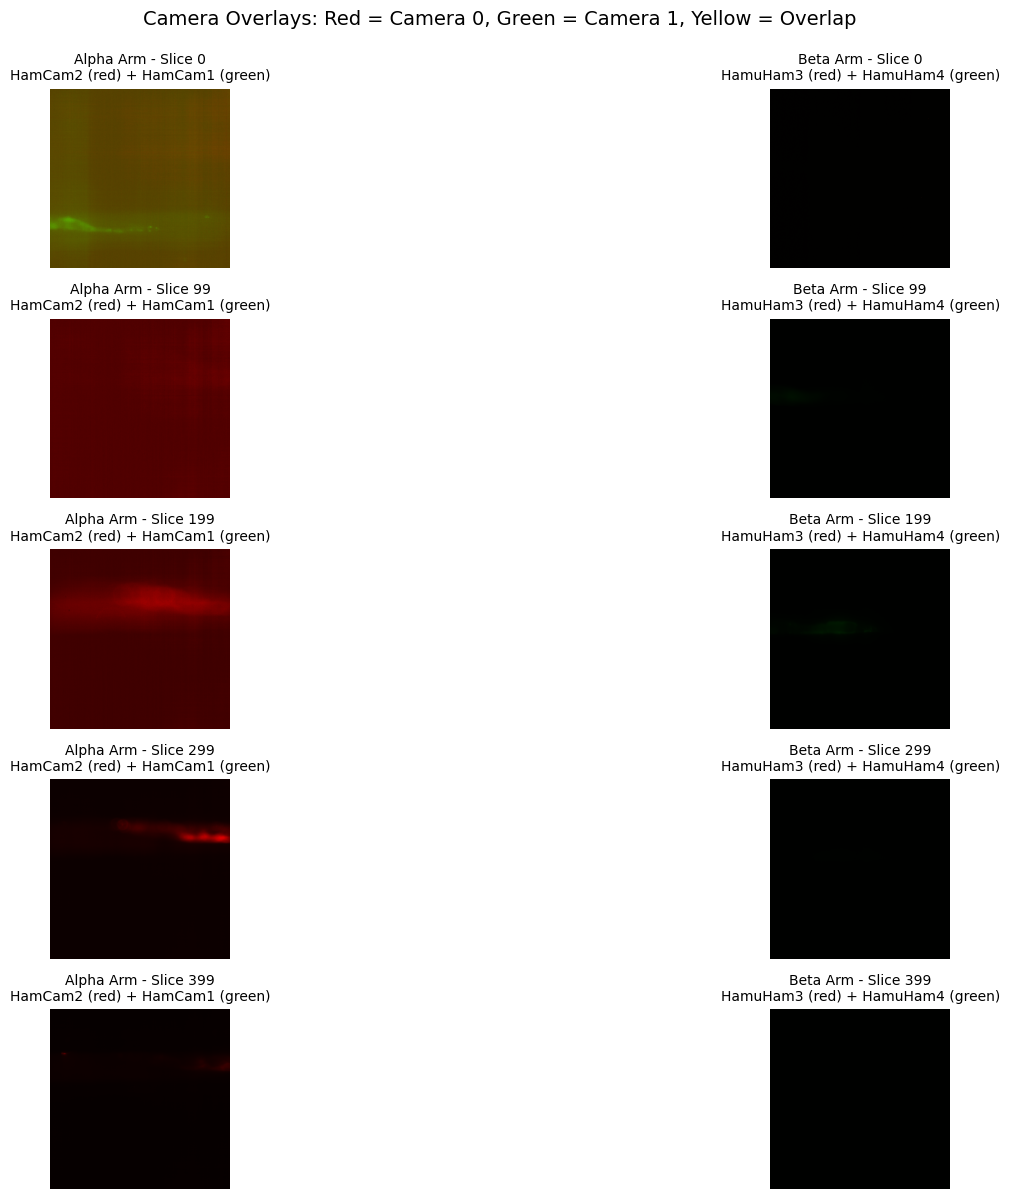

In [7]:
# Display camera overlays for multiple sample slices
if alpha_data is not None and beta_data is not None:
    # Display overlays for 5 sample slices across the volume
    fig = display_camera_overlays(
        alpha_data, 
        beta_data, 
        alpha_meta, 
        beta_meta,
        slice_indices=None,  # Will sample evenly across volume
        num_samples=5,
        figsize=(20, 12)
    )
    plt.show()
else:
    print("No data loaded to display overlays.")


## Section 5: Understanding Camera Relationships

### What to Look For in the Overlays

1. **Good Alignment**: Yellow regions indicate where both cameras see the same features
2. **Misalignment Indicators**:
   - **Translation**: Red and green features are shifted relative to each other
   - **Rotation**: Features appear rotated between cameras
   - **Scale differences**: Features appear different sizes
   - **Distortion**: Non-linear warping between camera views

3. **Camera Names**:
   - **Alpha arm**: HamCam2 (red) + HamCam1 (green)
   - **Beta arm**: HamuHam4 (red) + HamuHam3 (green)

### Next Steps for Alignment

To align cameras within each arm, you may need:
- **Affine transformation**: Translation, rotation, scaling
- **Non-rigid transformation**: For distortion correction
- **Feature-based registration**: Using beads or other landmarks
- **Intensity-based registration**: Optimizing overlap metrics


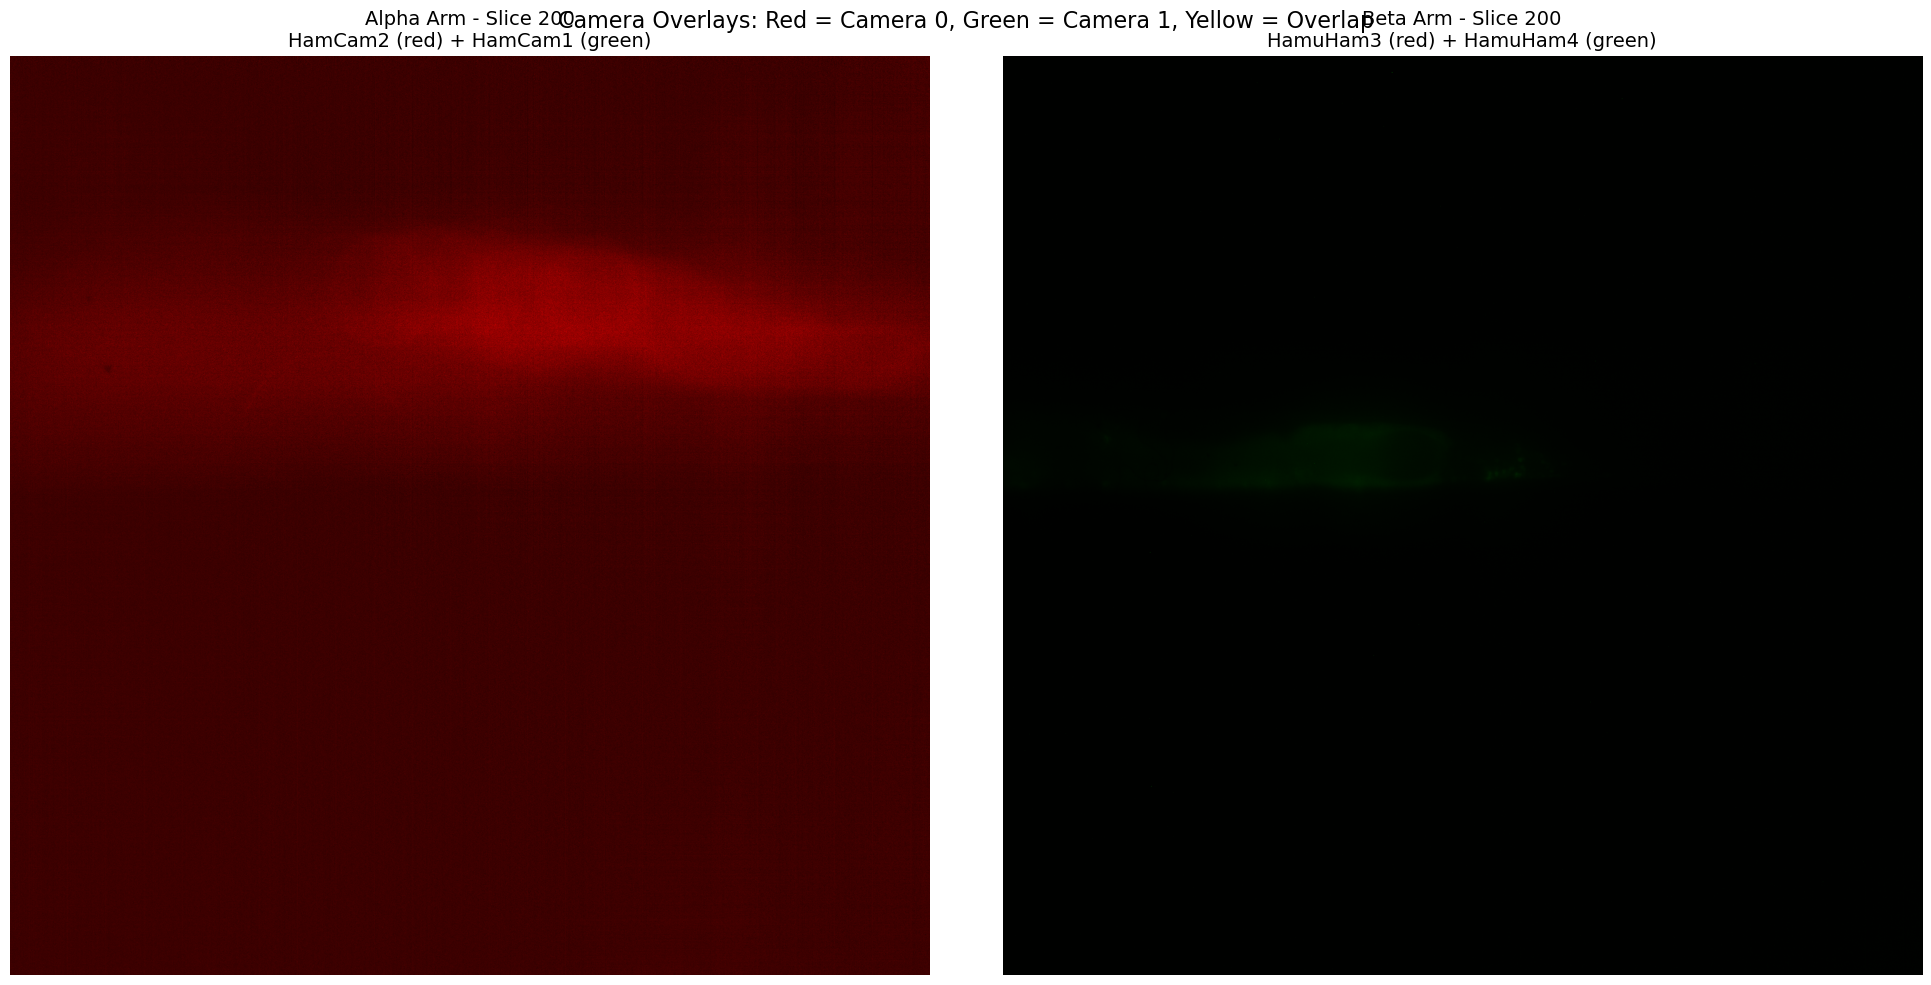

In [8]:
# Display a single slice overlay for closer inspection
if alpha_data is not None and beta_data is not None:
    # Select a slice in the middle of the volume
    slice_idx = alpha_data.shape[0] // 2
    
    # Extract camera images
    alpha_cam0 = alpha_data[slice_idx, 0, :, :]
    alpha_cam1 = alpha_data[slice_idx, 1, :, :]
    beta_cam0 = beta_data[slice_idx, 0, :, :]
    beta_cam1 = beta_data[slice_idx, 1, :, :]
    
    # Create overlays
    alpha_overlay = create_camera_overlay(alpha_cam0, alpha_cam1, 
                                         alpha_meta['channel_names'][0], 
                                         alpha_meta['channel_names'][1])
    beta_overlay = create_camera_overlay(beta_cam0, beta_cam1,
                                        beta_meta['channel_names'][0],
                                        beta_meta['channel_names'][1])
    
    # Display side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(alpha_overlay, aspect='equal')
    axes[0].axis('off')
    axes[0].set_title(f'Alpha Arm - Slice {slice_idx}\n'
                     f'{alpha_meta["channel_names"][0]} (red) + {alpha_meta["channel_names"][1]} (green)',
                     fontsize=14)
    
    axes[1].imshow(beta_overlay, aspect='equal')
    axes[1].axis('off')
    axes[1].set_title(f'Beta Arm - Slice {slice_idx}\n'
                     f'{beta_meta["channel_names"][0]} (red) + {beta_meta["channel_names"][1]} (green)',
                     fontsize=14)
    
    plt.suptitle('Camera Overlays: Red = Camera 0, Green = Camera 1, Yellow = Overlap',
                 fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded to display.")


## Section 6: Additional Visualizations

Optional: Create side-by-side videos or other visualizations for further analysis.


In [ ]:
# Optional: Create a side-by-side video (using first camera from each arm)
if alpha_data is not None and beta_data is not None:
    # Calculate appropriate frame rate based on slice period
    slice_period_ms = alignment['slice_period_ms']
    fps = 1000.0 / slice_period_ms  # frames per second
    # Cap at reasonable frame rate for video playback
    fps = min(fps, 30.0)
    
    print(f"Creating video at {fps:.2f} fps (based on {slice_period_ms:.2f} ms slice period)...")
    
    # Create output filename
    output_filename = f"{selected_acq['condition']}_{selected_acq['run']}_alpha_beta_video.mp4"
    
    # Create video (using first camera for both arms)
    video_path = create_video_from_stacks(
        alpha_data, 
        beta_data,
        output_filename,
        channel_alpha=0,
        channel_beta=0,
        fps=fps,
        max_slices=None,  # Use all loaded slices
        normalize=False
    )
    
    print(f"\nVideo saved to: {video_path}")
    print(f"You can play this video with any standard video player.")
else:
    print("No data loaded to create video.")


Creating video at 4.73 fps (based on 211.50 ms slice period)...
Creating video with 400 frames at 4.7281323877068555 fps...
  Processed 50/400 frames...
  Processed 100/400 frames...
  Processed 150/400 frames...
  Processed 200/400 frames...
  Processed 250/400 frames...
  Processed 300/400 frames...
  Processed 350/400 frames...
  Processed 400/400 frames...
Saving video to Worm1_starved_adult_SWF1188_I_alpha_beta_video.mp4...


[rawvideo @ 0x14d004570] Stream #0: not enough frames to estimate rate; consider increasing probesize


Video saved successfully!

Video saved to: Worm1_starved_adult_SWF1188_I_alpha_beta_video.mp4
You can play this video with any standard video player.


## Summary

### What We've Accomplished

1. **Data Loading**: Loaded OME-TIFF files with all cameras from both alpha and beta arms
2. **Camera Overlay Visualization**: Created red/green overlays to visualize spatial relationships
3. **Alignment Assessment**: Visualized how cameras within each arm relate to each other

### Key Findings

- **Data Structure**: Each arm has 2 cameras, 200 slices, 2304×2304 pixels
- **Camera Names**: 
  - Alpha: HamCam2, HamCam1
  - Beta: HamuHam4, HamuHam3
- **Spatial Calibration**: Pixel size and z-step extracted from metadata
- **Visualization**: Camera overlays help identify alignment needs

### Next Steps

1. **Camera Alignment**: Use the overlays to determine what transformations are needed
2. **Registration**: Apply transformations to align cameras within each arm
3. **Volume Reconstruction**: Combine aligned camera views for full volume reconstruction
4. **Cross-Arm Alignment**: After intra-arm alignment, align alpha and beta arms (90° rotation)


## Section 9: Example Usage

Now let's put it all together! We'll:
1. Select an acquisition pair
2. Load the data (with optional downsampling for initial exploration)
3. Display some frames
4. Create a sample video


In [9]:
# Select an acquisition to work with
# You can change this index to select a different acquisition
ACQUISITION_INDEX = 0  # 0 = first acquisition, 1 = second, etc.

if len(acquisitions) > ACQUISITION_INDEX:
    selected_acq = acquisitions[ACQUISITION_INDEX]
    print(f"Selected acquisition: {selected_acq['condition']}/{selected_acq['run']}")
    print(f"  Alpha: {selected_acq['alpha_path'].name}")
    print(f"  Beta: {selected_acq['beta_path'].name}")
else:
    print(f"Error: Acquisition index {ACQUISITION_INDEX} not available. Found {len(acquisitions)} acquisitions.")
    selected_acq = None


Selected acquisition: 10msec_worm/I
  Alpha: beads_alpha_worm2_4
  Beta: beads_beta_worm2_4


In [10]:
# Load metadata for selected acquisition
if selected_acq:
    print("Loading metadata...")
    alpha_meta = parse_metadata(selected_acq['alpha_metadata'])
    beta_meta = parse_metadata(selected_acq['beta_metadata'])
    
    print("\nAlpha metadata summary:")
    print(f"  Dimensions: {alpha_meta['width']}×{alpha_meta['height']}×{alpha_meta['slices']}")
    print(f"  Channels: {alpha_meta['channels']} ({', '.join(alpha_meta['channel_names'])})")
    print(f"  Start time: {alpha_meta['start_time']}")
    
    print("\nBeta metadata summary:")
    print(f"  Dimensions: {beta_meta['width']}×{beta_meta['height']}×{beta_meta['slices']}")
    print(f"  Channels: {beta_meta['channels']} ({', '.join(beta_meta['channel_names'])})")
    print(f"  Start time: {beta_meta['start_time']}")
    
    # Calculate temporal alignment
    alignment = calculate_temporal_alignment(alpha_meta, beta_meta)
    print(f"\nTemporal alignment:")
    print(f"  Time offset: {alignment['time_offset_sec']:.3f} seconds")
    print(f"  Average slice period: {alignment['slice_period_ms']:.2f} ms")
    
    # Extract spatial info
    spatial = extract_spatial_info(alpha_meta, beta_meta)
    print(f"\nSpatial information:")
    print(f"  Pixel size: {spatial['pixel_size_um']['average']:.4f} μm/pixel")
    print(f"  Z-step: {spatial['z_step_um']['average']:.4f} μm/slice")
    print(f"  Volume size: {spatial['physical_dimensions_um']['xy']['width']:.2f} × {spatial['physical_dimensions_um']['xy']['height']:.2f} × {spatial['physical_dimensions_um']['z']['depth']:.2f} μm")
else:
    print("No acquisition selected.")


Loading metadata...

Alpha metadata summary:
  Dimensions: 2304×2304×200
  Channels: 2 (HamCam2, HamCam1)
  Start time: 2025-11-12 16:49:53 -0500

Beta metadata summary:
  Dimensions: 2304×2304×200
  Channels: 2 (HamuHam4, HamuHam3)
  Start time: 2025-11-12 16:49:51 -0500

Temporal alignment:
  Time offset: -2.000 seconds
  Average slice period: 21.50 ms

Spatial information:
  Pixel size: 0.1220 μm/pixel
  Z-step: 0.7000 μm/slice
  Volume size: 281.09 × 281.09 × 140.00 μm


### Load Image Data

**Note**: Loading full stacks can be memory-intensive. For initial exploration, we'll load a subset of slices. 
You can adjust `MAX_SLICES_FOR_DISPLAY` to load more or fewer slices. Set to `None` to load all slices.


In [11]:
# Set maximum slices to load (None = load all, smaller number = faster loading for testing)
MAX_SLICES_FOR_DISPLAY = None  # Load full stack  # Change this to load more/fewer slices

if selected_acq:
    print("Loading OME-TIFF files...")
    print("This may take a few moments for large files...")
    
    # Load alpha data (first channel, limited slices)
    print("\nLoading alpha data...")
    alpha_data = load_ome_tiff(
        selected_acq['alpha_tiff'], 
        metadata=alpha_meta,
        channel_idx=None,  # Load all channels
        max_slices=MAX_SLICES_FOR_DISPLAY
    )
    
    # Load beta data (first channel, limited slices)
    print("\nLoading beta data...")
    beta_data = load_ome_tiff(
        selected_acq['beta_tiff'],
        metadata=beta_meta,
        channel_idx=None,  # Load all channels
        max_slices=MAX_SLICES_FOR_DISPLAY
    )
    
    print(f"\nData loaded successfully!")
    print(f"Alpha data shape: {alpha_data.shape}")
    print(f"Beta data shape: {beta_data.shape}")
    print(f"Alpha data dtype: {alpha_data.dtype}, range: [{alpha_data.min()}, {alpha_data.max()}]")
    print(f"Beta data dtype: {beta_data.dtype}, range: [{beta_data.min()}, {beta_data.max()}]")
else:
    print("No acquisition selected.")
    alpha_data = None
    beta_data = None


Loading OME-TIFF files...
This may take a few moments for large files...

Loading alpha data...
Loading OME-TIFF: datasets/10msec_worm/I/beads_alpha_worm2_4/beads_alpha_worm2_MMStack_Pos0.ome.tif
Raw data shape: (200, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (200, 2, 2304, 2304)

Loading beta data...
Loading OME-TIFF: datasets/10msec_worm/I/beads_beta_worm2_4/beads_beta_worm2_MMStack_Pos0.ome.tif
Raw data shape: (200, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (200, 2, 2304, 2304)

Data loaded successfully!
Alpha data shape: (200, 2, 2304, 2304)
Beta data shape: (200, 2, 2304, 2304)
Alpha data dtype: uint16, range: [17, 12712]
Beta data dtype: uint16, range: [0, 11448]


### Display Sample Frames

Let's visualize a few slices side-by-side to get a sense of the data.


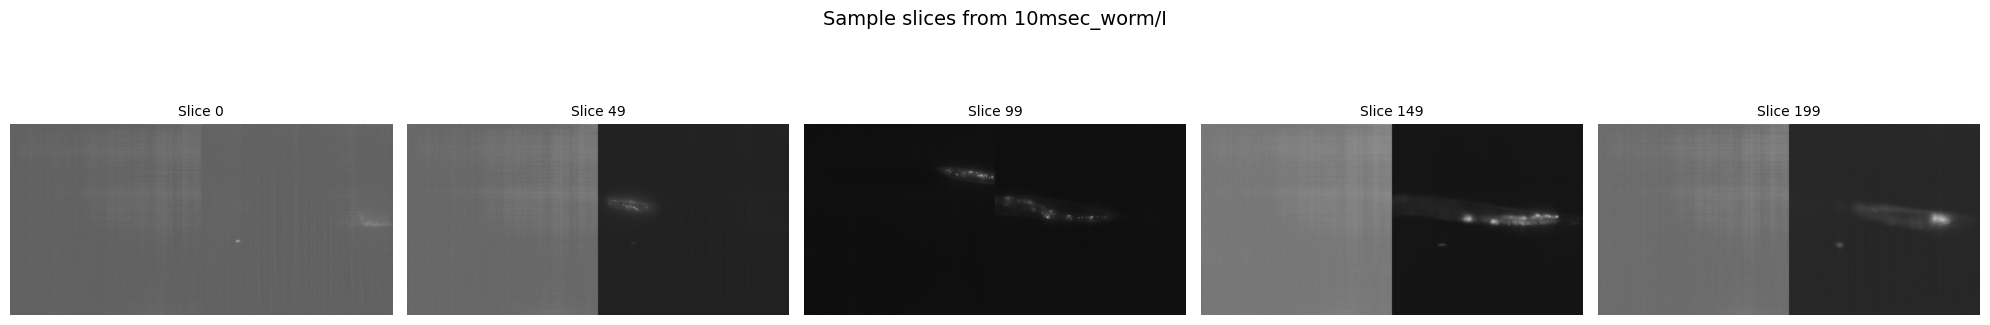

In [12]:
if alpha_data is not None and beta_data is not None:
    # Display a few sample slices
    num_samples = min(5, alpha_data.shape[0])
    sample_indices = np.linspace(0, alpha_data.shape[0] - 1, num_samples, dtype=int)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    if num_samples == 1:
        axes = [axes]
    
    for i, slice_idx in enumerate(sample_indices):
        # Extract slices (first channel)
        if len(alpha_data.shape) == 4:
            alpha_slice = alpha_data[slice_idx, 0, :, :]
            beta_slice = beta_data[slice_idx, 0, :, :]
        else:
            alpha_slice = alpha_data[slice_idx, :, :]
            beta_slice = beta_data[slice_idx, :, :]
        
        # Create side-by-side frame
        frame, _, _, _, _ = create_side_by_side_frame(alpha_slice, beta_slice, normalize=False)
        
        axes[i].imshow(frame, cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
        axes[i].set_title(f'Slice {slice_idx}', fontsize=10)
    
    plt.suptitle(f'Sample slices from {selected_acq["condition"]}/{selected_acq["run"]}', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded to display.")


### Create Video Output

Create a video file showing the alpha and beta channels side-by-side. The video will be saved in the current directory.


In [13]:
if alpha_data is not None and beta_data is not None:
    # Calculate appropriate frame rate based on slice period
    slice_period_ms = alignment['slice_period_ms']
    fps = 1000.0 / slice_period_ms  # frames per second
    # Cap at reasonable frame rate for video playback
    fps = min(fps, 30.0)
    
    print(f"Creating video at {fps:.2f} fps (based on {slice_period_ms:.2f} ms slice period)...")
    
    # Create output filename
    output_filename = f"{selected_acq['condition']}_{selected_acq['run']}_alpha_beta_video.mp4"
    
    # Create video (using first channel for both arms)
    video_path = create_video_from_stacks(
        alpha_data, 
        beta_data,
        output_filename,
        channel_alpha=0,
        channel_beta=0,
        fps=fps,
        max_slices=None,  # Use all loaded slices
        normalize=True
    )
    
    print(f"\nVideo saved to: {video_path}")
    print(f"You can play this video with any standard video player.")
else:
    print("No data loaded to create video.")


Creating video at 30.00 fps (based on 21.50 ms slice period)...
Creating video with 200 frames at 30.0 fps...
  Processed 50/200 frames...
  Processed 100/200 frames...
  Processed 150/200 frames...
  Processed 200/200 frames...
Saving video to 10msec_worm_I_alpha_beta_video.mp4...
Video saved successfully!

Video saved to: 10msec_worm_I_alpha_beta_video.mp4
You can play this video with any standard video player.


## Summary and Next Steps

### What We've Accomplished

1. **Metadata Parsing**: Successfully extracted acquisition parameters, dimensions, timing, and spatial information
2. **Data Loading**: Loaded OME-TIFF files with proper handling of multi-dimensional arrays
3. **Temporal Alignment**: Calculated timing offsets and frame alignment between alpha and beta arms
4. **Spatial Information**: Extracted pixel size, z-step, and position information for future registration
5. **Visualization**: Created side-by-side displays and interactive exploration tools
6. **Video Creation**: Generated video files for easy viewing

### Key Findings

- **Data Structure**: Each arm has 2 channels (two cameras), 200 slices, 2304×2304 pixels
- **Temporal Info**: Slice periods vary by acquisition condition (1ms, 10ms, 20ms, 200ms)
- **Spatial Calibration**: ~0.244 μm/pixel in XY, 0.7 μm between slices
- **Rotation**: 90° rotation between arms (MVRotations: "0_90") - important for future registration

### Future Work

1. **Image Registration**: Use spatial information to align/register alpha and beta volumes
2. **Fusion**: Combine registered alpha and beta data for improved resolution
3. **Segmentation**: Apply ML-based segmentation tools
4. **Multi-timepoint**: Extend to handle time-lapse data (currently single timepoint)
5. **Full Stack Loading**: Load complete stacks for full-resolution analysis

### Notes

- For memory efficiency, consider loading subsets of slices or downsampling for initial exploration
- The metadata contains extensive frame-by-frame information that could be used for more detailed temporal analysis
- Spatial positions (Position_X, Position_Y) can be used to align acquisitions from different positions
